In [26]:
import pandas as pd
import plotly.express as px
import pulp
import pyomo.environ as pyo
import random

# 1. Data

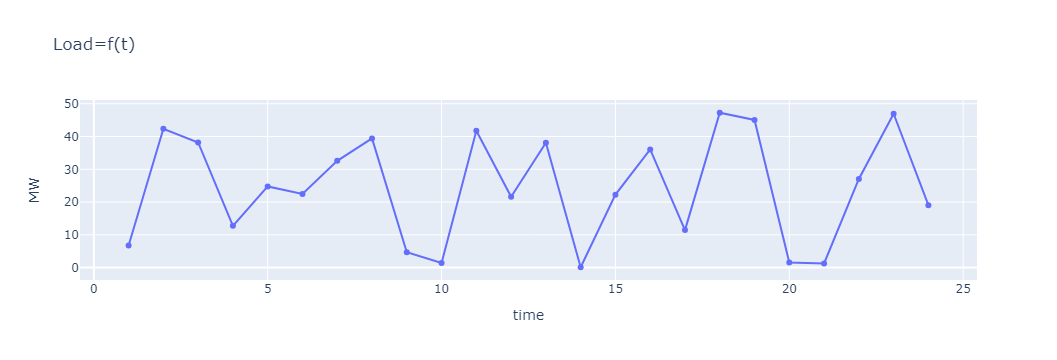

In [27]:
random.seed(1)
T = 24*1
df_load = pd.DataFrame(dict(
    time = [t for t in range(1,T+1)],
    power = [random.uniform(0,50) for _ in range(T)],
    type = "load"
))
fig = px.line(df_load, x="time", y="power", title="Load=f(t)",  markers=True) 
fig.update_layout(xaxis_title="time", yaxis_title="MW")
fig.show()

In [28]:
load = dict(zip(df_load.time,df_load.power))
#load

In [29]:
max(load.values())

47.263534777696115

# 2. Optimization

$$
\min \quad \sum_{t \in T} \text{\textcolor{blue}{deviation}}_t^2 
$$
subject to:
- deviation definition:
$$
\text{\textcolor{blue}{deviation}}_t = \text{load}_t - \text{\textcolor{blue}{prod}}_t \quad \forall t \in T
$$
- ramps are bounded:
$$ 
-10 \le \frac{\text{\textcolor{blue}{prod}}_{t+1}-\text{\textcolor{blue}{prod}}_{t}}{(t+1)-t} \le 10 \quad \forall t \in T
$$
- variables domains:
$$
\text{\textcolor{blue}{deviation}}_t \in \mathbb{R} \quad \forall t \in T
$$
$$
\text{\textcolor{blue}{prod}}_{t} \in \mathbb{R}^+ \quad \forall t \in T
$$

## 2.1 Minimize sum of squared deviations (Pyomo - Ipopt)

In [30]:
# create LP
model = pyo.ConcreteModel()
model.T = pyo.RangeSet(T) #model.T.data()

# VARIABLES
model.prod = pyo.Var(model.T,domain=pyo.NonNegativeReals,bounds=(0,max(load.values())))
model.deviation = pyo.Var(model.T)

# CONSTRAINTS
model.ramp_up = pyo.ConstraintList()
model.ramp_down = pyo.ConstraintList()
model.deviation_def = pyo.ConstraintList()

for t in model.T:
    model.deviation_def.add(expr=model.deviation[t] == model.prod[t] - load[t])
    if t<T:
        model.ramp_up.add(expr=model.prod[t+1] - model.prod[t] <= 10)
        model.ramp_down.add(expr=model.prod[t+1] - model.prod[t] >= -10)
        

# OBJ
model.obj = pyo.Objective(expr=sum((model.deviation[t])**2 for t in model.T), sense=pyo.minimize)

pyo.SolverFactory("ipopt").solve(model,tee=True)

print(pyo.value(model.obj))

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:       48
Number of nonzeros in inequality constraint Jacobian.:       92
Number of nonzeros in Lagrangian Hessian.............:       24

Total number of variables............................:       48
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       24


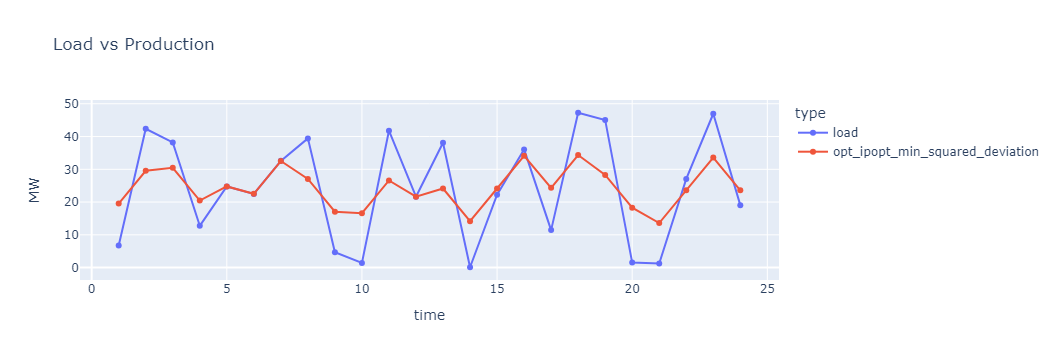

In [31]:
df_sol_ipopt = pd.DataFrame(dict(
    time = [t for t in range(1,T+1)],
    power = [pyo.value(model.prod[t]) for t in range(1,T+1)],
    type = "opt_ipopt_min_squared_deviation"
))

fig = px.line(pd.concat([df_load,df_sol_ipopt]), x="time", y="power",color="type", title="Load vs Production", markers=True) 
fig.update_layout(xaxis_title="time", yaxis_title="MW")
fig.show()

In [32]:
max(abs(pyo.value(model.prod[t])-load[t]) for t in range(1,T+1))

16.77093681447829

In [33]:
sum((pyo.value(model.prod[t])-load[t])**2 for t in range(1,T+1))

2874.0379547702405

## 2.2 Other possible objective functions

### Minimize maximum deviation 

$$
\min \quad \max_{t \in T}\{ |\text{\textcolor{blue}{deviation}}_t| \}
$$
subject to:
- deviation definition:
$$
\text{\textcolor{blue}{deviation}}_t = \text{load}_t - \text{\textcolor{blue}{prod}}_t \quad \forall t \in T
$$
- ramps are bounded:
$$ 
-10 \le \frac{\text{\textcolor{blue}{prod}}_{t+1}-\text{\textcolor{blue}{prod}}_{t}}{(t+1)-t} \le 10 \quad \forall t \in T
$$

In [34]:
# create LP
prob = pulp.LpProblem("min_max_deviation", pulp.LpMinimize)

# prod[t] = amount of energy produced at time t
prod = pulp.LpVariable.dicts("prod",[t for t in range(1,T+1)],lowBound=0, cat=pulp.LpContinuous)

# max deviation with respect to load
max_deviation = pulp.LpVariable("max_deviation", lowBound=0, cat=pulp.LpContinuous)

# objective function : minimize max deviation
prob += max_deviation

# max deviation definition
for t in range(1,T+1):
    prob += max_deviation >= prod[t] - load[t]
    prob += max_deviation >= -prod[t] + load[t]

# prod'[t] is bounded
for t in range(1,T):
    prob += prod[t+1]-prod[t] <= 10
    prob += -10 <= prod[t+1]-prod[t] 

#prob 
prob.solve()
print("status =", prob.status)
print("obj =",pulp.value(prob.objective))
for t in range(1,T+1):
    if abs(pulp.value(prod[t])-load[t]) >= pulp.value(prob.objective)-1e-3:
        print(t,"   load:",load[t], "  prod",pulp.value(prod[t]),"   deviation=",abs(pulp.value(prod[t])-load[t]))
#print("")
#for t in prod:
#    print(t, pulp.value(prod[t]))

status = 1
obj = 16.770937
2    load: 42.371686846861635   prod 25.60075    deviation= 16.770936846861634
3    load: 38.1887309488307   prod 21.417794    deviation= 16.770936948830702
5    load: 24.771754354597046   prod 8.0008175    deviation= 16.770936854597046
7    load: 32.579648636138145   prod 15.808712    deviation= 16.770936636138146
8    load: 39.43616755677566   prod 22.665231    deviation= 16.77093655677566
11    load: 41.788255195993486   prod 25.017318    deviation= 16.770937195993486
13    load: 38.1140041228971   prod 21.343067    deviation= 16.7709371228971
16    load: 36.07700161703913   prod 19.306065    deviation= 16.77093661703913
18    load: 47.263534777696115   prod 30.492598    deviation= 16.770936777696114
19    load: 45.07137288057418   prod 28.300436    deviation= 16.77093688057418
20    load: 1.5294991516776768   prod 18.300436    deviation= 16.770936848322325
23    load: 46.95745813892553   prod 30.186521    deviation= 16.770937138925532


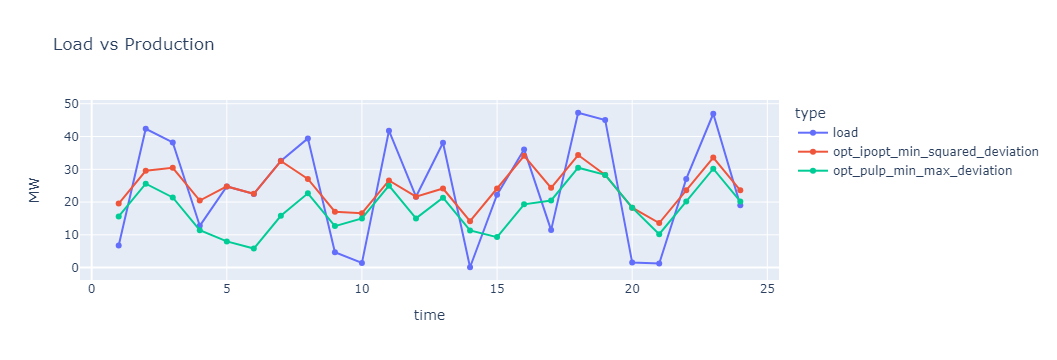

In [35]:
df_sol_pulp = pd.DataFrame(dict(
    time = [t for t in range(1,T+1)],
    power = [pulp.value(prod[t]) for t in range(1,T+1)],
    type = "opt_pulp_min_max_deviation"
))

fig = px.line(pd.concat([df_load,df_sol_ipopt,df_sol_pulp]), x="time", y="power",color="type", title="Load vs Production", markers=True) 
fig.update_layout(xaxis_title="time", yaxis_title="MW")
fig.show()

In [36]:
sum((pulp.value(prod[t])-load[t])**2 for t in load)

4530.399995123677

### Minimize sum of absolute deviations 

$$
\min \quad \sum_{t \in T} |\text{\textcolor{blue}{deviation}}_t| 
$$
subject to:
- deviation definition:
$$
\text{\textcolor{blue}{deviation}}_t = \text{load}_t - \text{\textcolor{blue}{prod}}_t \quad \forall t \in T
$$
- ramps are bounded:
$$ 
-10 \le \frac{\text{\textcolor{blue}{prod}}_{t+1}-\text{\textcolor{blue}{prod}}_{t}}{(t+1)-t} \le 10 \quad \forall t \in T
$$

In [37]:
# create LP
prob = pulp.LpProblem("sum_abs_deviation", pulp.LpMinimize)

# prod[t] = amount of energy produced at time t
prod = pulp.LpVariable.dicts("prod",[t for t in range(1,T+1)],lowBound=0, cat=pulp.LpContinuous)

# deviation[t] with respect to load
deviation = pulp.LpVariable.dicts("deviation",[t for t in range(1,T+1)], lowBound=0, cat=pulp.LpContinuous)

# objective function : minimize max deviation
prob += pulp.lpSum(deviation)

# max deviation definition
for t in range(1,T+1):
    prob += deviation[t] >= prod[t] - load[t]
    prob += deviation[t] >= -prod[t] + load[t]

# prod'[t] is bounded
for t in range(1,T):
    prob += prod[t+1]-prod[t] <= 10
    prob += -10 <= prod[t+1]-prod[t] 

#prob 
prob.solve()
print("status =", prob.status)
print("obj =",pulp.value(prob.objective))
#print("")
#for t in prod:
#    print(t, pulp.value(prod[t]))

status = 1
obj = 221.18713729999996


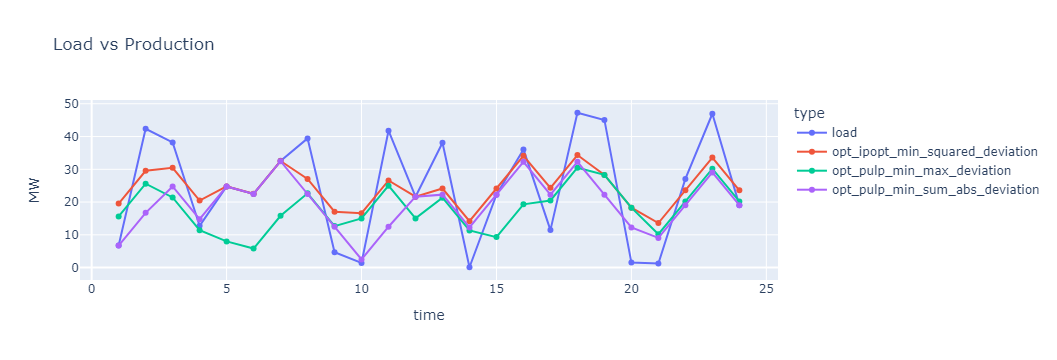

In [38]:
df_sol_pulp2 = pd.DataFrame(dict(
    time = [t for t in range(1,T+1)],
    power = [pulp.value(prod[t]) for t in range(1,T+1)],
    type = "opt_pulp_min_sum_abs_deviation"
))

fig = px.line(pd.concat([df_load,df_sol_ipopt,df_sol_pulp,df_sol_pulp2]), x="time", y="power",color="type", title="Load vs Production", markers=True) 
fig.update_layout(xaxis_title="time", yaxis_title="MW")
fig.show()

In [39]:
sum((pulp.value(prod[t])-load[t])**2 for t in load)

3886.9232548817445

## 2.3 Minimize sum of squared deviations with tangents approximation

<img src="tangents.png" alt="Alternative text" width=500 />

In [41]:
# create LP
prob = pulp.LpProblem("energy", pulp.LpMinimize)

# prod[t] = amount of energy produced at time t
prod = pulp.LpVariable.dicts("prod",[t for t in range(1,T+1)],lowBound=0, cat=pulp.LpContinuous)
# deviation[t] with respect to load
deviation = pulp.LpVariable.dicts("deviation",[t for t in range(1,T+1)], lowBound=0, cat=pulp.LpContinuous)
deviation_squared =  pulp.LpVariable.dicts("deviation_squared",[t for t in range(1,T+1)], lowBound=0, cat=pulp.LpContinuous)


# objective function : minimize squared deviations
prob += pulp.lpSum(deviation_squared[t] for t in range(1,T+1))

# deviation definition
for t in range(1,T+1):
    prob += prod[t] - load[t] <= deviation[t]
    prob += -prod[t] + load[t] <= deviation[t]
    
# deviation squared approx with tangents
for t in range(1,T+1):
    for a in range(100):
        prob += deviation_squared[t] >= 2*a*deviation[t]-a**2

# ramp constraints    
for t in range(1,T):
    prob += prod[t+1]-prod[t] <= 10
    prob += -10 <= prod[t+1]-prod[t]

#prob 
prob.solve()
print("status =", prob.status)
print("obj =",pulp.value(prob.objective))
print("")
#for t in prod:
    #print(t, pulp.value(prod[t]))

status = 1
obj = 2872.5984606999996



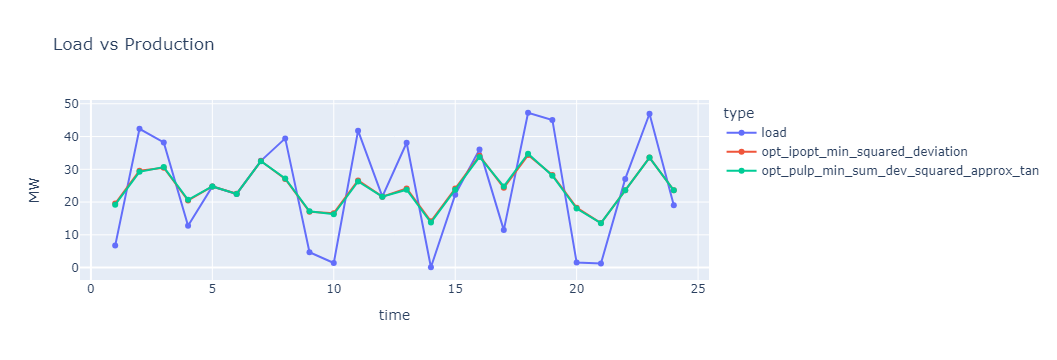

In [42]:
df_sol_pulp3 = pd.DataFrame(dict(
    time = [t for t in range(1,T+1)],
    power = [pulp.value(prod[t]) for t in range(1,T+1)],
    type = "opt_pulp_min_sum_dev_squared_approx_tan"
))

fig = px.line(pd.concat([df_load,
                         df_sol_ipopt,
                         #df_sol_pulp,
                         #df_sol_pulp2,
                         df_sol_pulp3]), x="time", y="power",color="type", title="Load vs Production", markers=True) 
fig.update_layout(xaxis_title="time", yaxis_title="MW")
fig.show()

In [43]:
sum((pulp.value(prod[t])-load[t])**2 for t in load)

2875.625328152434

## 2.4 Minimize sum of squared deviations with secants approximation

<img src="secants.png" alt="Alternative text" width=500 />

In [44]:
# create LP
prob = pulp.LpProblem("energy", pulp.LpMinimize)

# prod[t] = amount of energy produced at time t
prod = pulp.LpVariable.dicts("prod",[t for t in range(1,T+1)],lowBound=0, cat=pulp.LpContinuous)

# deviation with respect to load
deviation = pulp.LpVariable.dicts("deviation",[t for t in range(1,T+1)], lowBound=0, cat=pulp.LpContinuous)
deviation_squared = pulp.LpVariable.dicts("deviation_squared",[t for t in range(1,T+1)], lowBound=0, cat=pulp.LpContinuous)
deviation_sec = pulp.LpVariable.dicts("deviation_sec",([t for t in range(1,T+1)],[a for a in range(100)]), lowBound=0, upBound=1, cat=pulp.LpContinuous)

# objective function : minimize squared deviations
prob += pulp.lpSum(deviation_squared)

# deviation definition
for t in range(1,T+1):
    prob += prod[t] - load[t] <= deviation[t]
    prob += -prod[t] + load[t] <= deviation[t]
    
# deviation squared approx with secants
for t in range(1,T+1):
    prob += deviation[t] == pulp.lpSum(deviation_sec[t][a] for a in range(100))
    prob += deviation_squared[t] == pulp.lpSum((2*(a-1)+1)*deviation_sec[t][a] for a in range(100))

# ramp constraints    
for t in range(1,T):
    prob += prod[t+1]-prod[t] <= 10
    prob += -10 <= prod[t+1]-prod[t]

prob.solve()
print("status =", prob.status)
print("obj =",pulp.value(prob.objective))
print("")
#for t in prod:
#    print(t, pulp.value(prod[t]))

status = 1
obj = 2435.1605771000004



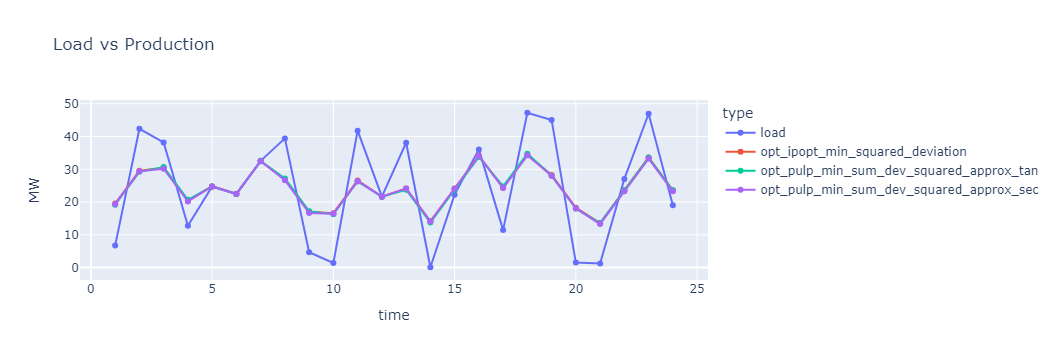

In [46]:
df_sol_pulp4 = pd.DataFrame(dict(
    time = [t for t in range(1,T+1)],
    power = [pulp.value(prod[t]) for t in range(1,T+1)],
    type = "opt_pulp_min_sum_dev_squared_approx_sec"
))

fig = px.line(pd.concat([df_load,
                         df_sol_ipopt,
                         #df_sol_pulp,
                         #df_sol_pulp2,
                         df_sol_pulp3,
                         df_sol_pulp4,
                        ]), x="time", y="power",color="type", title="Load vs Production", markers=True) 
fig.update_layout(xaxis_title="time", yaxis_title="MW")
fig.show()

In [47]:
sum((pulp.value(prod[t])-load[t])**2 for t in load)

2875.146741484219

In [24]:
sum((pyo.value(model.prod[t])-load[t])**2 for t in range(1,T+1))

4940.886618447867

## 2.5 Minimize sum of squared deviations with Pyomo integrated piecewise approximation 

https://github.com/Pyomo/pyomo/blob/main/examples/pyomo/piecewise/step.py 

https://yetanothermathprogrammingconsultant.blogspot.com/2019/02/piecewise-linear-functions-and.html

https://github.com/Pyomo/pyomo/blob/main/examples/pyomo/piecewise/indexed.py

In [48]:
# create LP
model = pyo.ConcreteModel()
model.T = pyo.RangeSet(T) #model.T.data()
max_load = max(load.values())

# prod[t] = amount of energy produced at time t
model.prod = pyo.Var(model.T,domain=pyo.NonNegativeReals,bounds=(0,max_load))
model.deviation = pyo.Var(model.T,domain=pyo.NonNegativeReals,bounds=(0,max_load))
model.deviation_squared = pyo.Var(model.T,domain=pyo.NonNegativeReals,bounds=(0,max_load**2))

# CONSTRAINTS
model.ramp_up = pyo.ConstraintList()
model.ramp_down = pyo.ConstraintList()
model.deviation_def = pyo.ConstraintList()

for t in model.T:
    model.deviation_def.add(expr=model.prod[t] - load[t] <= model.deviation[t])
    model.deviation_def.add(expr=-model.prod[t] + load[t] <= model.deviation[t])
    if t<T:
        model.ramp_up.add(expr=model.prod[t+1] - model.prod[t] <= 10)
        model.ramp_down.add(expr=model.prod[t+1] - model.prod[t] >= -10)

x_data = [a for a in range(0,int(max_load)+2)]
y_data = [a**2 for a in range(0,int(max_load)+2)]

for t in model.T:
    #print("t=",t)
    model.add_component("%s"%t, pyo.Piecewise(
        model.deviation_squared[t],
        model.deviation[t],  
        pw_pts=x_data,
        pw_constr_type='EQ',
        f_rule=y_data,
        #pw_repn= 'BIGM_BIN' #'SOS2' #'CC' #'SOS2', #'INC'?
    ))
                                                  
# OBJ
model.obj = pyo.Objective(expr=sum(model.deviation_squared[t] for t in model.T), sense=pyo.minimize)

In [49]:
pyo.SolverFactory("cbc").solve(model,tee=True)
print(pyo.value(model.obj))

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 18 2023 

command line - C:\Users\Romain\Desktop\SOLVERS\CBC 2.10.10\bin\cbc.exe -printingOptions all -import C:\Users\Romain\AppData\Local\Temp\tmppbizjfcv.pyomo.lp -stat=1 -solve -solu C:\Users\Romain\AppData\Local\Temp\tmppbizjfcv.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 165 (-1) rows, 1224 (-24) columns and 3690 (-26) elements
Statistics for presolved model


Problem has 165 rows, 1224 columns (24 with objective) and 3690 elements
There are 24 singletons with objective 
Column breakdown:
0 of type 0.0->inf, 1224 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
48 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
23 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
70 of type L other, 0 of type 

In [50]:
# model.pprint()

In [51]:
sum((pyo.value(model.prod[t])-load[t])**2 for t in load)

2875.146741405554

In [52]:
sum(pyo.value(model.deviation_squared[t]) for t in load)

2877.2373801000003

In [53]:
sum((pyo.value(model.deviation[t]))**2 for t in load)

2875.146735572667

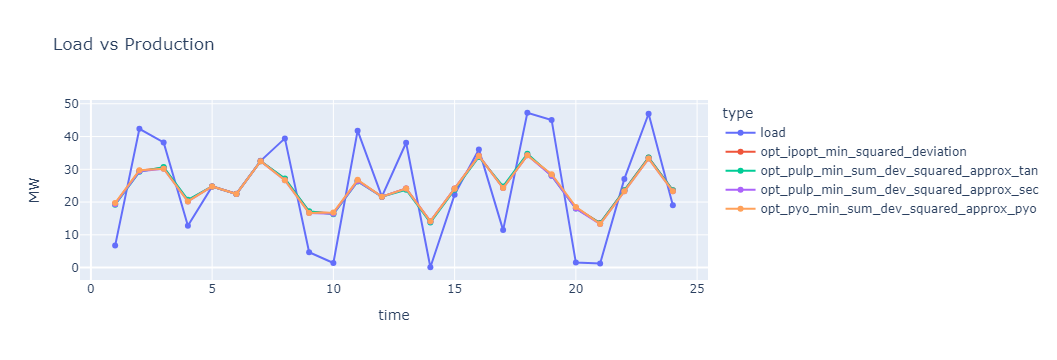

In [54]:
df_sol_pyo = pd.DataFrame(dict(
    time = [t for t in range(1,T+1)],
    power = [pyo.value(model.prod[t]) for t in range(1,T+1)],
    type = "opt_pyo_min_sum_dev_squared_approx_pyo"
))

fig = px.line(pd.concat([df_load,
                         df_sol_ipopt,
                         #df_sol_pulp,
                         #df_sol_pulp2,
                         df_sol_pulp3,
                         df_sol_pulp4,
                         df_sol_pyo]), x="time", y="power",color="type", title="Load vs Production", markers=True) 
fig.update_layout(xaxis_title="time", yaxis_title="MW")
fig.show()